In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split


In [8]:
df_train = pd.read_csv('../../Dataset/Non_Outlier/kendaraan_train_clean.csv')
df_train.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.0,0.153846,1.0,0.634615,1.0,0.0,0.0,0.409000,0.932099,0.301038,0
1,1.0,0.430769,1.0,0.750000,0.0,2.0,1.0,0.367431,0.172840,0.512111,0
2,1.0,0.015385,1.0,0.884615,1.0,0.0,0.0,0.496727,0.981481,0.377163,0
3,1.0,0.461538,1.0,0.673077,0.0,2.0,1.0,0.536338,0.537037,0.636678,0
4,1.0,0.015385,1.0,0.673077,1.0,0.0,0.0,0.310270,0.932099,0.557093,0


In [9]:
def transform_data(df):
	X = df.drop('Tertarik', axis=1)
	y = df['Tertarik']

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	X_train = np.clip(np.array(X_train), -5, 5)
	X_test = np.clip(np.array(X_test), -5, 5)
	y_train = np.clip(np.array(y_train), -5, 5)
	y_test = np.clip(np.array(y_test), -5, 5)

	return X_train, X_test, y_train, y_test
 

def define_model(n_input):
	metrics = [
		keras.metrics.BinaryAccuracy(name='accuracy'),
		keras.metrics.Precision(name='precision'),
		keras.metrics.Recall(name='recall'),
		keras.metrics.AUC(name='auc'),
		keras.metrics.AUC(name='prc', curve='PR'),
	]

	model = Sequential()
	model.add(Dense(64, activation="relu", input_shape=(n_input,)))
	model.add(Dense(32, activation="relu"))
	model.add(Dropout(0.5)),
	model.add(Dense(1, activation='sigmoid'))

	model.compile(
		optimizer=keras.optimizers.Adam(learning_rate=1e-3),
		loss=BinaryCrossentropy(),
		metrics=metrics
	)

	return model


def calculate_class_weight(df):
	total = len(df)

	neg = len(df[df['Tertarik'] == 0])
	pos = len(df[df['Tertarik'] == 1])

	weight_for_0 = (1 / neg) * (total / 2.0)
	weight_for_1 = (1 / pos) * (total / 2.0)
	weights = {0: weight_for_0, 1: weight_for_1}

	return weights


EarlyStop = EarlyStopping(
    monitor='auc',
    patience=6,
    mode='max',
    restore_best_weights=True
)

trainX, trainy, testX, testy = transform_data(df_train)

### **Melatih Model Deep Learning** 

In [10]:
model = define_model(trainX.shape[1])

history = model.fit(
    trainX, testX,
    epochs=100,
    class_weight=calculate_class_weight(df_train),
    verbose=1,
    callbacks=EarlyStop,
    batch_size=128
)


Epoch 1/100
1442/1442 [==============================] - 5s 2ms/step - loss: 0.4483 - accuracy: 0.6695 - precision: 0.2589 - recall: 0.9410 - auc: 0.8315 - prc: 0.3052A: 2s - loss: 0.4964 - accuracy: 0.6529 - precision: 0.24
Epoch 2/100
1442/1442 [==============================] - 3s 2ms/step - loss: 0.4327 - accuracy: 0.6834 - precision: 0.2681 - recall: 0.9462 - auc: 0.8418 - prc: 0.3163
Epoch 3/100
1442/1442 [==============================] - 3s 2ms/step - loss: 0.4297 - accuracy: 0.6917 - precision: 0.2729 - recall: 0.9418 - auc: 0.8456 - prc: 0.3278A: 1s - loss: 0.4276 - accuracy: 0.6936 - precision: 0.2727 - recall: 0.9400 - auc: 0.8464 -  - ETA: 0s - loss: 0.4283 - accuracy: 0.6920 - precision: 0.2725 - recall: 0.9413 - auc: 0.845
Epoch 4/100
1442/1442 [==============================] - 3s 2ms/step - loss: 0.4287 - accuracy: 0.6947 - precision: 0.2744 - recall: 0.9380 - auc: 0.8464 - prc: 0.3258
Epoch 5/100
1442/1442 [==============================] - 3s 2ms/step - loss: 0.4286 

### **Evaluasi Model**

In [11]:
def plot_cm(labels, predictions, p=0.5):
    predictions = model.predict(predictions)
    cm = confusion_matrix(labels, predictions > p)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d')

    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    return predictions

1442/1442 [==============================] - 2s 1ms/step - loss: 0.4718 - accuracy: 0.6848 - precision: 0.2693 - recall: 0.9507 - auc: 0.8517 - prc: 0.3423


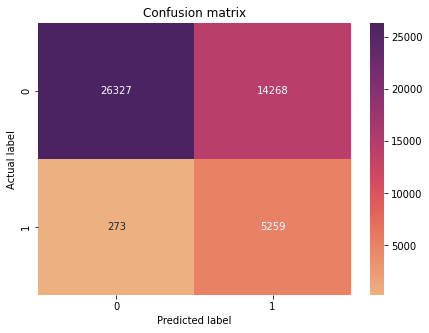

loss :  0.4717862010002136
accuracy :  0.684761643409729
precision :  0.26931941509246826
recall :  0.9506507515907288
auc :  0.8516935706138611
prc :  0.3423099219799042
f1-score : 0.4197294385250808


In [12]:
baseline_results = model.evaluate(trainy, testy)
predictions = plot_cm(testy, trainy)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

print('f1-score :', f1_score(testy, predictions > 0.5))

### **Prediksi Dan Evaluasi Data Test**

In [13]:
df = pd.read_csv('../../Dataset/kendaraan_test_clean.csv')
df.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0,0.446154,1,0.153846,0,1,1,0.082475,0.154321,0.467128,0
1,1,0.030769,1,0.903846,1,0,0,0.068822,0.932099,0.799308,0
2,1,0.061538,1,0.538462,1,0,0,0.200636,0.932099,0.179931,0
3,1,0.400000,1,0.153846,1,1,0,0.062575,0.759259,0.083045,0
4,1,0.230769,1,0.442308,0,1,1,0.045268,0.932099,0.757785,0


In [14]:
trainy = df.drop('Tertarik', axis=1)
testy = df['Tertarik']

1489/1489 [==============================] - 3s 1ms/step - loss: 0.4733 - accuracy: 0.6849 - precision: 0.2725 - recall: 0.9352 - auc: 0.8469 - prc: 0.3462


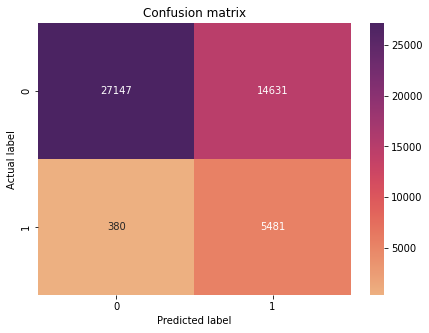

loss :  0.4732956290245056
accuracy :  0.6849009990692139
precision :  0.2725238800048828
recall :  0.9351646304130554
auc :  0.8469291925430298
prc :  0.34622013568878174
f1-score : 0.42205367112000913


In [15]:
baseline_test_results = model.evaluate(trainy, testy)
predictions = plot_cm(testy, trainy)

for name, value in zip(model.metrics_names, baseline_test_results):
  print(name, ': ', value)

print('f1-score :', f1_score(testy, predictions > 0.5))